# Machine Learning Models and Ensemble Method
---


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # disable GPU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

SEED = 111 # constant seed for reproducibility
#os.environ['PYTHONHASHSEED'] = str(SEED)
#np.random.seed(SEED)
#tf.random.set_seed(SEED)


## Train/Test Split:

In [2]:
df = pd.read_csv("UFC_TRAIN.csv")

# tackling imbalance issue
theMin = df["Winner"].value_counts().min()
minority = df[df["Winner"]==1].iloc[0:theMin]
undersampleMaj = df[df["Winner"]==0].iloc[0:theMin]
df = pd.concat([minority, undersampleMaj], axis=0)
df["Winner"].value_counts()

# train/test split
X = df.drop(["date","Winner","B_fighter","R_fighter"], axis=1).values
y = df["Winner"].values
X_TRAIN, X_TEST, y_TRAIN, y_TEST = train_test_split(X,y, test_size=0.1, random_state=SEED)



#### Baseline: Always predict red (i.e: 0)

In [3]:
metrics.accuracy_score(np.zeros(len(df.index)),df["Winner"])

0.5

Baseline accuracy is 67.96 % in unbalanced dataset

## ML Models
### 1- DNN:
Using a deep neural network with early stopping functionality to prevent divergence of loss & val_loss

In [4]:
# scaling
scaler = MinMaxScaler()
scaler.fit(X_TRAIN)
X_train = scaler.transform(X_TRAIN)
X_test = scaler.transform(X_TEST)
y_train = y_TRAIN
y_test = y_TEST
print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape} | y_train shape: {y_train.shape} | y_test shape: {y_test.shape}")

# model
dnnClf = Sequential()

# input layer
dnnClf.add(Dense(units=42, activation='relu'))
dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

dnnClf.add(Dense(units=42, activation='relu'))
dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

#dnnClf.add(Dense(units=42, activation='relu'))
#dnnClf.add(Dropout(0.5)) # deactivates 50% of nodes

#dnnClf.add(Dense(units=42, activation='relu'))

#dnnClf.add(Dense(units=42, activation='relu'))

# output layer
dnnClf.add(Dense(units=1, activation='sigmoid'))

dnnClf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping # prevent divergence of loss & val_loss
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=16)

X_train shape: (2404, 42) | X_test shape: (268, 42) | y_train shape: (2404,) | y_test shape: (268,)


Train on 2404 samples, validate on 268 samples
Epoch 1/400
2404/2404 [==============================] - 2s 903us/sample - loss: 0.6977 - accuracy: 0.5270 - val_loss: 0.6932 - val_accuracy: 0.4925
Epoch 2/400
2404/2404 [==============================] - 0s 149us/sample - loss: 0.6946 - accuracy: 0.5062 - val_loss: 0.6902 - val_accuracy: 0.5037
Epoch 3/400
2404/2404 [==============================] - 0s 153us/sample - loss: 0.6919 - accuracy: 0.5316 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 4/400
2404/2404 [==============================] - 0s 157us/sample - loss: 0.6891 - accuracy: 0.5324 - val_loss: 0.6877 - val_accuracy: 0.5448
Epoch 5/400
2404/2404 [==============================] - 1s 312us/sample - loss: 0.6818 - accuracy: 0.5574 - val_loss: 0.6863 - val_accuracy: 0.5560
Epoch 6/400
2404/2404 [==============================] - 0s 160us/sample - loss: 0.6842 - accuracy: 0.5607 - val_loss: 0.6837 - val_accuracy: 0.5634
Epoch 7/400
2404/2404 [==============================] - 0s

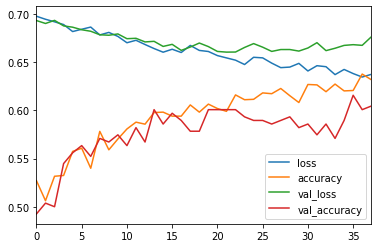

In [5]:
dnnClf.fit(x=X_train, 
          y=y_train, 
          epochs=400,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )
model_loss = pd.DataFrame(dnnClf.history.history)
model_loss.plot()

In [6]:
dnnPreds = dnnClf.predict(scaler.transform(X_TEST))
dnnPreds = [round(i[0]) for i in dnnPreds]
dnnAcc = metrics.accuracy_score(dnnPreds, y_TEST)
print("DNN Accuracy:",round(dnnAcc,3))

DNN Accuracy: 0.604


### 2- SVM:
Using a Support Vector Machine with a linear kernel

In [7]:
svmClf = SVC(kernel="linear")
svmClf.fit(X_TRAIN,y_TRAIN)
svmPreds = svmClf.predict(X_TEST)
svmAcc = metrics.accuracy_score(svmPreds, y_TEST)
print("SVM Accuracy:",round(svmAcc,3))

# svm hp-tuning with gridSearch
#svm_param = {"kernel":("linear","poly","rbf", "sigmoid"),
#            "C":[1,52,10],
#            "degree":[3,8],
#            "gamma":("auto","scale"),
#            "coef0":[0.001,10,0.5]}
#svmClf = SVC()
#svmGrid = GridSearchCV(svmClf, svm_param,cv=2)
#svmGrid.fit(X_TRAIN, y_TRAIN)

SVM Accuracy: 0.601


### 3- RF:
Random Forest

In [8]:
rfClf = RandomForestRegressor(n_estimators = 100, random_state = SEED)
rfClf.fit(X_TRAIN, y_TRAIN)
rfPreds = rfClf.predict(X_TEST)
rfPreds = [round(i) for i in rfPreds]
rfAcc = metrics.accuracy_score(rfPreds,y_TEST)
print("RF Accuracy:",round(rfAcc,3))

RF Accuracy: 0.601


### 4- Ensemble Method:
Ensemble method aggregates the votes of each model and gives the most frequent vote as output

In [9]:
def predictEnsemble(sample):
    print("=",end="")
    dnnPred = dnnClf.predict(scaler.transform(sample.reshape(1,-1))).tolist()[0][0]
    svmPred = svmClf.predict(sample.reshape(1,-1)).tolist()[0]
    rfPred = rfClf.predict(sample.reshape(1,-1)).tolist()[0]
    
    ensPred = []
    ensPred.append([dnnPred,svmPred,rfPred])
    ensPred = [round(i) for i in ensPred[0]]
    #print(ensPred)
    
    return(max(set(ensPred), key=ensPred.count)) # return mode, i.e: most frequent

ensPreds = []
[ensPreds.append(predictEnsemble(e)) for e in X_TEST]
ensAcc = metrics.accuracy_score(ensPreds,y_TEST)
print("\nEnsemble Accuracy:",round(ensAcc,3))

Ensemble Accuracy: 0.612


## Performance Evaluation:

In [10]:
print("Accuracy on unseen test dataset")
TEST = pd.read_csv("UFC_TEST.csv")
TESTX = TEST.drop(["date","B_fighter","R_fighter","Winner"],axis=1).values
TESTY = TEST["Winner"].values

dnnPreds2 = dnnClf.predict(scaler.transform(TESTX))
dnnPreds2 = [round(i[0]) for i in dnnPreds2]
dnnAcc2 = metrics.accuracy_score(dnnPreds2, TESTY)
print("DNN Accuracy:",round(dnnAcc2,3))

svmPreds2 = svmClf.predict(TESTX)
svmAcc2 = metrics.accuracy_score(svmPreds2, TESTY)
print("SVM Accuracy:",round(svmAcc2,3))

rfPreds2 = rfClf.predict(TESTX)
rfPreds2 = [round(i) for i in rfPreds2]
rfAcc2 = metrics.accuracy_score(rfPreds2, TESTY)
print("RF Accuracy:",round(rfAcc2,3))

ensPreds2 = []
[ensPreds2.append(predictEnsemble(e)) for e in TESTX]
ensAcc2 = metrics.accuracy_score(ensPreds2,TESTY)
print("\nEnsemble Accuracy:",round(ensAcc2,3))

Accuracy on unseen test dataset
DNN Accuracy: 0.627
SVM Accuracy: 0.608
RF Accuracy: 0.584
Ensemble Accuracy: 0.634


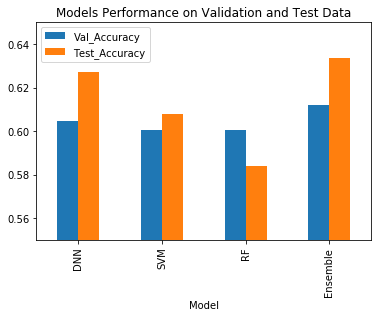

In [12]:
accTable = pd.DataFrame({"Model":["DNN","SVM","RF","Ensemble"], "Val_Accuracy":[dnnAcc,svmAcc,rfAcc,ensAcc],
                         "Test_Accuracy":[dnnAcc2,svmAcc2,rfAcc2,ensAcc2]})
accTable.plot(kind="bar",ylim=(0.55,0.65),x="Model",title="Models Performance on Validation and Test Data")